<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab4/blob/main/Hall/Hall_cold_measurements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab4 Hall: Measurements on cold sample (at room temperature)


Evgeny Kolonsky 2025

v.0.1.1


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit
import requests

# The procedure outline

1. Collect data at zero magnetic field to extract misalignment voltage $U_m$ slope and offset, and get **resistivity** $\rho$:
$$
U_m = \beta U_p + U_0,
$$
$$
\rho = \frac{U_p}{I_p}  \frac{W d}{L}, \quad B=0.
$$
with $W=10$ mm, $L=16$ mm, $d=1$ mm
2. Collect data at various $B$ and $I_p$.
3. Extract **Hall coefficent** $R_H$ from $U_H$ vs $B\cdot I_p$:
$$
R_H = \frac{U_H \cdot d}{B\cdot I_p}
$$
4. Calculate **Hall mobility**
$$
\mu_H = \frac{R_H}{\rho}
$$
5. Independently find drift mobility $\mu_p$ from magnetoresistance:
$$
\frac{\rho(B) - \rho|_{B=0}}{\rho|_{B=0}} \approx (\mu_p B)^2
$$
6. Compute the **Hall factor** $r_H$:
$$
r_H = \frac{\mu_H}{\mu_p}.
$$

Expected value at 300K 	*for high purity p-Ge* is about $r_H=1.8$. [source: Ioffe](https://www.ioffe.ru/SVA/NSM/Semicond/Ge/electric.html)

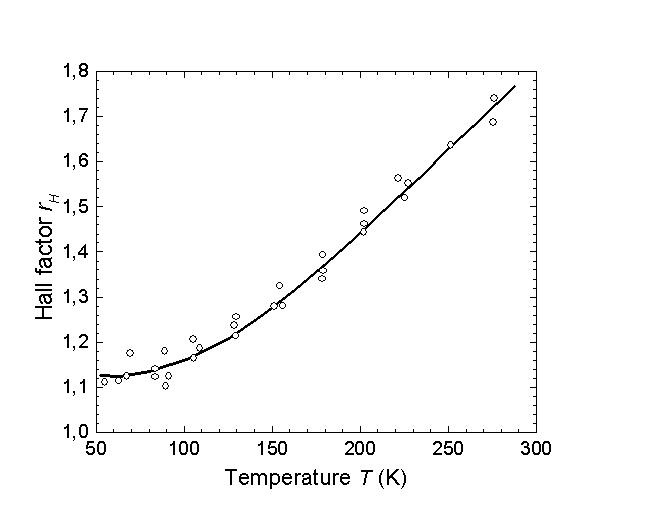

In [9]:
# Constants
W = 10e-3 #mm
L = 16e-3 #mm
d = 1e-3  #mm

# Sample 23 p-Ge

# Step 1. Zero magnetic field




Slope beta = 0.049, offset U0 = -0.1 mV
Resistance rho = 0.030 Ohm m


Text(0, 0.5, 'Observed Hall voltage $U_H$, mV')

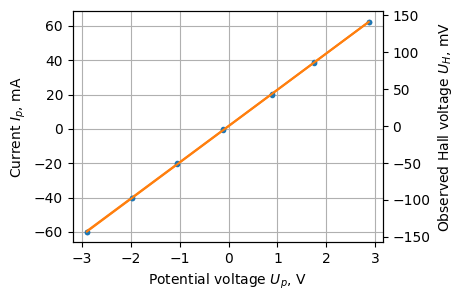

In [35]:
zero = '''
#B = 0
# Ip/mA, Up/mV, Uh/mV
-60 -2900 -143.38
-40 -1983 -97.30
-20 -1046 -51.36
0.01 -106 -5.25
20 891 43.83
39 1754 86.20
62 2869 141.20
'''

Ip, Up, Uh = np.genfromtxt(zero.splitlines()).T
Ip *= 1e-3
Up *= 1e-3
Uh *= 1e-3

# uncertaities
Ip_err = 1e-3 #mA
Ip_rel = Ip_err / Ip
U_err = 1e3 #mV
Uh_rel = U_err / Up


fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax1 = ax.twinx()
fit_conductivity = linregress(Up, Ip)
fit_leak = linregress(Up, Uh)
beta, U0 = fit_leak.slope, fit_leak.intercept
print(f'Slope beta = {beta:.3f}, offset U0 = {U0*1e3:.1f} mV')

R = 1 /  fit_conductivity.slope
rho = R * W * d / L
print(f'Resistance rho = {rho:.3f} Ohm m')

ax.plot(Up, Ip*1e3, '.')
ax.plot(Up, 1e3*(fit_conductivity.intercept + fit_conductivity.slope * Up))
ax.set_xlabel(r'Potential voltage $U_p$, V')
ax.set_ylabel(r"Current $I_p$, mA")
ax.grid()


ax1.plot(Up, Uh*1e3, '.')
ax1.plot(Up, (beta*Up + U0)*1e3)
ax1.set_ylabel(r"Observed Hall voltage $U_H$, mV")


## Step 2. Measurements at non-zero magnetic field



In [11]:
def weighted_average(values, errors):
  weights = 1 / errors**2
  average  = np.sum(weights * values) / np.sum(weights)
  error_of_average = np.sqrt(1 / np.sum(weights))
  return average, error_of_average

### Getting raw data

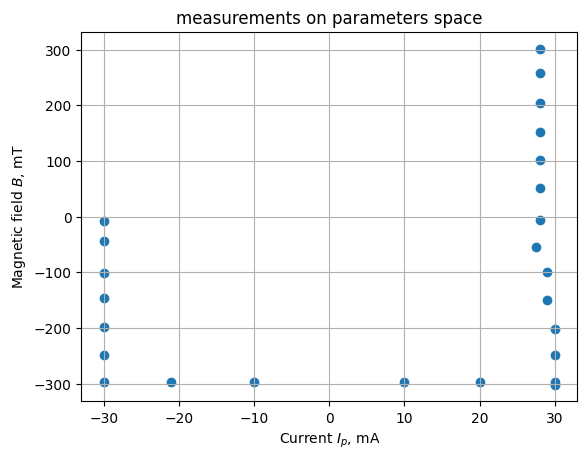

In [36]:
data = '''
# Ip/mA, Up/mV, Uh/mV, B/mT
30 1350 8.89 302
30 1338 17.45 248
30 1329 25.28 202
29 1320 34.67 150
29 1315 44.11 100
27.5 1244 50.60 54
28 1242 59.74 6
28 1242 71.28 -51
28 1244 80.85 -101
28 1250 90.56 -152
28 1257 99.98 -204
28 1265 109.50 -259
28 1272 116.62 -302
#40 1854 12.86 300
30 1394 9.89 298
20 894 6.34 297
10 466 3.29 297
#0 -53 -0.33 297
-10 -574 -3.98 297
-21 -1106 -7.77 297
-30 -1521 -10.76 297
-30 -1507 -19.71 248
-30 -1495 -29.23 198
-30 -1485 -39.64 147
-30 -1479 -49.21 101
-30 -1472 -62.14 44
-30 -1470 -70.53 7
'''
Ip, Up, Uh, B = np.genfromtxt(data.splitlines()).T
Ip *= 1e-3
Up *= 1e-3
Uh *= 1e-3
B *= -1e-3

# uncertaities
Ip_err = 1e-3 #mA
Ip_rel = Ip_err / Ip
U_err = 1e3 #mV
Uh_rel = U_err / Up
B_err = 5e-3 # let's assume error in B is 5 mT
B_rel = B_err / B

plt.scatter(Ip*1e3, B*1e3)
plt.xlabel(r'Current $I_p$, mA')
plt.ylabel(r'Magnetic field $B$, mT')
plt.title('measurements on parameters space')
plt.grid()

# Step 3. Extract $R_H$ after zero correction
$$
R_H = \frac{U_H \cdot d}{B\cdot I_p}
$$

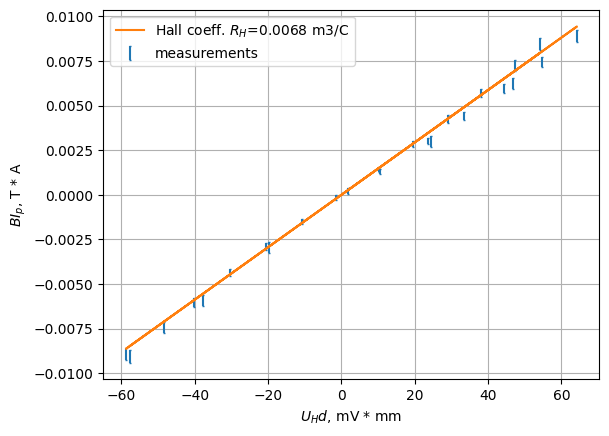

In [37]:
# hall voltage zero correction
Uh_ = Uh - beta * Up - U0


y = B * Ip
# relative error
y_rel = np.sqrt(B_rel**2 + Ip_rel**2)
y_err = np.abs(y * y_rel)
# Error by x is negligible
x = Uh_ * d
fit = linregress(x, y)
k = fit. slope
k_error  = fit.stderr
#k, k_error  = weighted_average(y/x, y_err/x)
k_rel = np.abs(k_error / k)
RH = 1 / k
RH_err =  RH * k_rel

plt.errorbar(x*1e6, y, yerr=y_err,  capsize=1, linestyle='', label='measurements')
plt.plot(x*1e6, (k * x), label=fr'Hall coeff. $R_H$={RH:.4f} m3/C')
plt.grid()
plt.ylabel(r'$B I_p$, T * A')
plt.xlabel(r'$U_H d$, mV * mm')

plt.legend()

In [38]:
print(f'Measured value RH = {RH*1e3:.2f} ± {RH_err*1e3:.2f} 10^-3 m3/C')

Measured value RH = 6.81 ± 0.08 10^-3 m3/C


#  Step  4. Calculate Hall mobility
$$
\mu_H = \frac{R_H}{\rho}
$$

<TBD>

In [39]:
mu_H = RH / rho
print(f'Measured value mu_H = {mu_H:.2f} m2 / Vs')

Measured value mu_H = 0.23 m2 / Vs


Reference for the Hall mobility value: [source](https://www.researchgate.net/publication/387388986_Investigation_of_the_electrical_properties_and_carrier_concentration_in_n-_and_p-doped_germanium):

$\mu_H = 0.238(5) $ m2/Vs for p-Germanium.

$\mu_H = 0.257(5) $ m2/Vs for n-Germanium.

The measured result of sample #23 p-Ge is consistent with reference value.

#Step 5. Find drift mobility $\mu_p$ from magnetoresistance:
$$
\frac{\rho(B) - \rho|_{B=0}}{\rho|_{B=0}} \approx (\mu_p B)^2
$$

Measured value mu_p = 0.09 +- 0.00 m2 / Vs


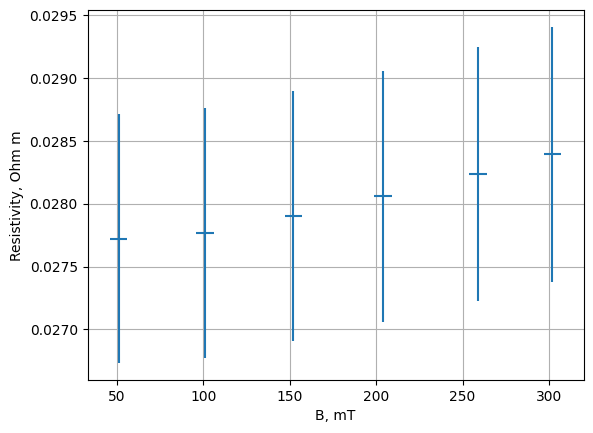

In [40]:
data = '''
# Ip/mA, Up/mV, Uh/mV, B/mT
#30 1350 8.89 302
#30 1338 17.45 248
#30 1329 25.28 202
#29 1320 34.67 150
#29 1315 44.11 100
#27.5 1244 50.60 54
#28 1242 59.74 6
28 1242 71.28 -51
28 1244 80.85 -101
28 1250 90.56 -152
28 1257 99.98 -204
28 1265 109.50 -259
28 1272 116.62 -302
#40 1854 12.86 300
#30 1394 9.89 298
#20 894 6.34 297
#10 466 3.29 297
#0 -53 -0.33 297
#-10 -574 -3.98 297
#-21 -1106 -7.77 297
#-30 -1521 -10.76 297
#-30 -1507 -19.71 248
#-30 -1495 -29.23 198
#-30 -1485 -39.64 147
#-30 -1479 -49.21 101
#-30 -1472 -62.14 44
#-30 -1470 -70.53 7
'''
Ip, Up, Uh, B = np.genfromtxt(data.splitlines()).T
Ip *= 1e-3
Up *= 1e-3
Uh *= 1e-3
B *= -1e-3

# uncertaities
Ip_err = 1e-3 #mA
Ip_rel = Ip_err / Ip
U_err = 1e3 #mV
Uh_rel = U_err / Up
B_err = 5e-3 # let's assume error in B is 5 mT
B_rel = B_err / B

rhoB =  Up/Ip * W * d / L
rhoB_rel = Ip_rel
rhoB_err = np.abs(rhoB * rhoB_rel)
plt.errorbar(B*1e3, rhoB, yerr=rhoB_err, xerr=B_err*1e3, linestyle='')

def model(x, a, offset):
  return (a * x)**2 + offset

parameters, parameters_covariance = curve_fit(model, B, rhoB, sigma=rhoB_err)

mu_p = parameters[0]
mu_p_err = np.sqrt(np.diag(parameters_covariance))[0]
print(f'Measured value mu_p = {mu_p:.2f} +- {mu_p_err:.2f} m2 / Vs')
#plt.plot(B*1e3, model(B, *parameters))
plt.xlabel('B, mT')
plt.ylabel('Resistivity, Ohm m')
plt.grid()

Magnetoresistance can not be extracted from data with given current measurement accuracy.

Measurements to get magnetoresistance should be performed with constant $I_p$. Technically it means that the experimenter should set the $I_p$ current and do not touch it further, since the current redings accuracy is low.

#Step 6. Compute the Hall factor $r_H$:
$$
r_H = \frac{\mu_H}{\mu_p}.
$$

In [41]:
r_H = mu_H / mu_p
print(f'Measured value r_H = {r_H:.2f}')

Measured value r_H = 2.62


The expected Hall factor value at temperature $T\approx 300K$ is $r_H = 1.8$. [source:Ioffe](https://www.ioffe.ru/SVA/NSM/Semicond/Ge/electric.html) Value $r_H=2.14$ is far from reasonable. The reason is big uncertainty in drift factor $\mu_p$ (magnetoresistance measurements).

# Conclusion

The "Cold experiment" (measurements at room temperature) allows to find **Hall coefficient** $R_H$ and **Hall mobility** $\mu_H$ with rather good accuracy and reasonable values.

Due to low resolution of current $I_p$ readings, second-order changes in resistivity versus  magnetic field $B$ (**magnetoresistivity**) are hard to define accurately, especially when current was changed during measurements. In case when magnetoresistivity experiment is performed succesfully, at constant current, and clear parabolic form of relative resistance to $\frac{\delta \rho}{\rho} = (\mu_p B)^2$ is observed, the **drift mobility** $\mu_p$ and respectively **Hall factor** $r_H=\frac{\mu_H}{\mu_p}$ values can be extracted.

The Hall factor $r_H$ is unitless value depending on temperature. It's reference value at 300K is $r_H = 1.8(1)$.

# Sample 14 n-Ge

## Step 1 Zero

Slope beta = -0.003, offset U0 = 6.1 mV
Resistance rho = 0.025 Ohm m


/tmp/ipython-input-4292463582.py:20: RuntimeWarning: divide by zero encountered in divide
  Ip_rel = Ip_err / Ip


Text(0, 0.5, 'Observed Hall voltage $U_H$, mV')

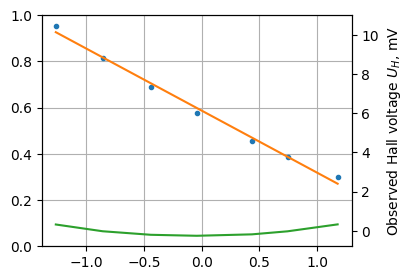

In [42]:
zero = '''
#B = 0
# Ip mA, Up mV, UH mV
-30 -1264 10.46
-20 -858 8.83
-9 -441 7.33
0 -43 6.02
12 435 4.58
20 743 3.76
30 1177 2.74
'''

Ip, Up, Uh = np.genfromtxt(zero.splitlines()).T
Ip *= 1e-3
Up *= 1e-3
Uh *= 1e-3

# uncertaities
Ip_err = 1e-3 #mA
Ip_rel = Ip_err / Ip
U_err = 1e3 #mV
Uh_rel = U_err / Up


fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax1 = ax.twinx()
fit_conductivity = linregress(Up, Ip)
fit_leak = linregress(Up, Uh)
beta, U0 = fit_leak.slope, fit_leak.intercept
print(f'Slope beta = {beta:.3f}, offset U0 = {U0*1e3:.1f} mV')

R = 1 /  fit_conductivity.slope
rho = R * W * d / L
print(f'Resistance rho = {rho:.3f} Ohm m')

#ax.plot(Up, Ip*1e3, '.')
#ax.plot(Up, 1e3*(fit_conductivity.intercept + fit_conductivity.slope * Up))
#ax.set_xlabel(r'Potential voltage $U_p$, V')
#ax.set_ylabel(r"Current $I_p$, mA")
ax.grid()


ax1.plot(Up, Uh*1e3, '.')
ax1.plot(Up, (beta*Up + U0)*1e3)
ax1.plot(Up, Uh*1e3 - (beta*Up + U0)*1e3)
ax1.set_ylabel(r"Observed Hall voltage $U_H$, mV")


## Step 2 Raw data

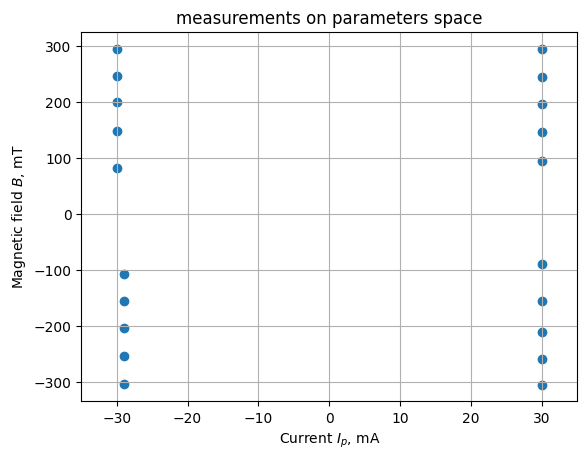

In [85]:
data = '''
# Ip mA, Up mV, UH mV, B mT
-29 -1277 -74.32 -299
-29 -1264 -63.74 -248
-29 -1253 -53.19 -198
-29 -1246 -43.38 -150
-29 -1242 -33.59 -102
-30 -1289 7.35 88
-30 -1288 21.15 154
-30 -1289 31.86 205
-30 -1291 41.69 252
-30 -1293 51.72 301
30 1167 -39.68 301
30 1161 -30.49 251
30 1154 -21.22 202
30 1149 -11.51 151
30 1145 -1.93 100
30 1144 33.53 -85
30 1146 45.86 -151
30 1148 55.86 -205
30 1153 65.01 -254
30 1156  73.30 -300
'''
Ip, Up, Uh, B = np.genfromtxt(data.splitlines()).T
Ip *= 1e-3
Up *= 1e-3
Uh *= 1e-3
B -= 5
B  *= 1e-3

# uncertaities
Ip_err = 1e-3 #mA
Ip_rel = Ip_err / Ip
U_err = 1e3 #mV
Uh_rel = U_err / Up
B_err = 5e-3 # let's assume error in B is 5 mT
B_rel = B_err / B

plt.scatter(Ip*1e3, B*1e3)
plt.xlabel(r'Current $I_p$, mA')
plt.ylabel(r'Magnetic field $B$, mT')
plt.title('measurements on parameters space')
plt.xlim(-35, 35)
plt.grid()

## Step 3 Extract $R_H$

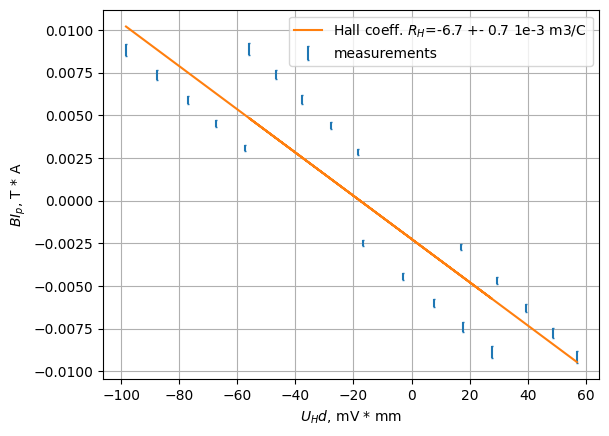

In [86]:
# hall voltage zero correction
Uh_ = Uh - beta * Up - U0
Uh_ = Uh - beta * Up - 20e-3


y = B * Ip
# relative error
y_rel = np.sqrt(B_rel**2 + Ip_rel**2)
y_err = np.abs(y * y_rel)
# Error by x is negligible
x = Uh_ * d
fityx = linregress(y, x)
RH = fityx. slope
RH_err  = fityx.stderr

fitxy = linregress(x, y)

plt.errorbar(x*1e6, y, yerr=y_err,  capsize=1, linestyle='', label='measurements')
plt.plot(x*1e6, fitxy.slope *x + fitxy.intercept, label=fr'Hall coeff. $R_H$={RH*1e3:.1f} +- {RH_err*1e3:.1f} 1e-3 m3/C')
plt.grid()
plt.ylabel(r'$B I_p$, T * A')
plt.xlabel(r'$U_H d$, mV * mm')

plt.legend()

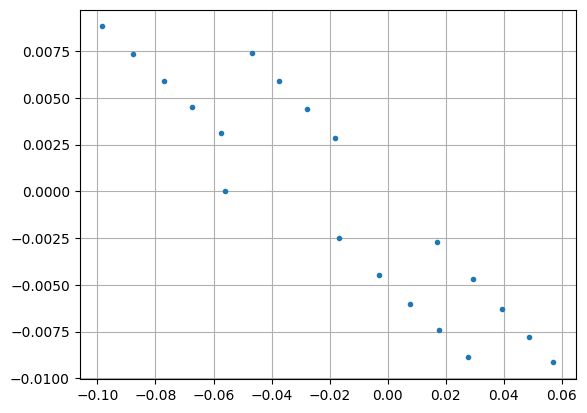

In [83]:
plt.plot(Uh_, B*Ip, '.')
plt.grid()

## Step 4. Get $\mu_H$

In [64]:
mu_H = RH / rho
mu_H_err = np.abs(mu_H * RH_err / RH)
print(f'Measured value mu_H = {mu_H:.2f} +- {mu_H_err:.2f} m2 / Vs')

Measured value mu_H = -0.27 +- 0.03 m2 / Vs


# Step 5. Magnetoresistance


/tmp/ipython-input-4024481344.py:1: RuntimeWarning: divide by zero encountered in divide
  rhoB =  Up/Ip * W * d / L
/usr/local/lib/python3.12/dist-packages/matplotlib/axes/_axes.py:3803: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err


ValueError: array must not contain infs or NaNs

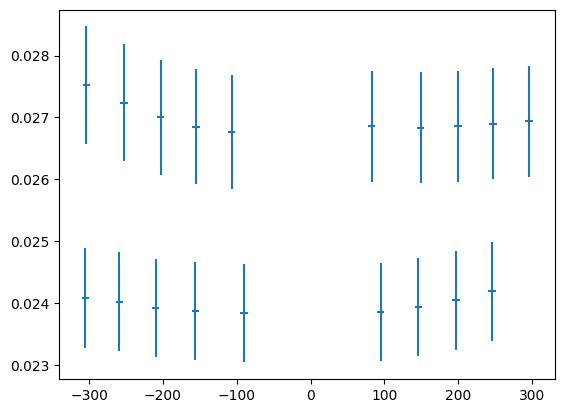

In [84]:
rhoB =  Up/Ip * W * d / L
rhoB_rel = Ip_rel
rhoB_err = np.abs(rhoB * rhoB_rel)
plt.errorbar(B*1e3, rhoB, yerr=rhoB_err, xerr=B_err*1e3, linestyle='')

def model(x, a, offset):
  return (a * x)**2 + offset

parameters, parameters_covariance = curve_fit(model, B, rhoB, sigma=rhoB_err)

mu_p = parameters[0]
mu_p_err = np.sqrt(np.diag(parameters_covariance))[0]
print(f'Measured value mu_p = {mu_p:.2f} +- {mu_p_err:.2f} m2 / Vs')
#plt.plot(B*1e3, model(B, *parameters))
plt.xlabel('B, mT')
plt.ylabel('Resistivity, Ohm m')
plt.grid()